In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf  
import pathlib
import math
import os
import re
import cv2
import sklearn
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import f1_score
import pickle

<h3>Configure Tensorflow</h3>

In [2]:
config = tf.compat.v1.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
config.log_device_placement = True  # to log device placement (on which device the operation ran)  
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.compat.v1.Session(config=config)  
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras  


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:08:00.0, compute capability: 7.5



<h3> Load dataset </h3>
<h4> (skip if data is already pickled) </h4>

In [3]:
test_set_percentage = 20
image_size = 224 # nxn
training_set_chunks = 4

dataset_path = '../histology_slides/'
dataset_path = pathlib.Path(dataset_path)

paths = []

# search every file in the directory
print('Finding image paths...')
for path in dataset_path.rglob("*"):
    filename, file_extension = os.path.splitext(path)

    # find images
    if file_extension == '.png':
        paths.append(path)

print('%d unique images found' % (len(paths)))

# shuffle the paths
paths = sklearn.utils.shuffle(paths)

test_size = math.floor(len(paths) * test_set_percentage / 100)

#use the last n samples of the list for testing
paths_test = paths[len(paths) - test_size : len(paths)]
#trim off the last n samples of the list from the main training set
paths = paths[0 : len(paths) - test_size]

# load testing set
labels_test = []
images_test = []

prog = 0

print('Preparing test set...')
for path in paths_test:
    filename, file_extension = os.path.splitext(path)

    #filename format:
    #<BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>_<YEAR>-<SLIDE_ID>-<MAGNIFICATION>-<SEQ>
    meta = re.split('_|-', os.path.basename(filename)) # metadata

    tumor_class = meta[1]
    tumor_type = meta[2]

    # get label
    if tumor_class == 'B':
        labels_test.append(0)
    elif tumor_class == 'M':
        labels_test.append(1)
    else:
        print('ERROR: Unrecognized tumor type')

    # load image
    img = np.asarray(Image.open(path).convert("RGB"))
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0 # scale pixel data between 0 and 1
    images_test.append(img)

    prog += 1

    print('%d images loaded\r' % (prog), end="")
    
labels_test = np.array(labels_test)
images_test = np.array(images_test)
print('\nDone')

print('Saving test set...')
pickle.dump(images_test, open("../saved/images_test.p", "wb"), protocol=4)
pickle.dump(labels_test, open("../saved/labels_test.p", "wb"), protocol=4)
print('Done')

# free memory
del(images_test)
del(labels_test)

# load testing set
labels = []
images = []

prog = 0

print('Preparing training set...')
for path in paths:
    filename, file_extension = os.path.splitext(path)
    
    #filename format:
    #<BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>_<YEAR>-<SLIDE_ID>-<MAGNIFICATION>-<SEQ>
    meta = re.split('_|-', os.path.basename(filename)) # metadata

    tumor_class = meta[1]
    tumor_type = meta[2]

    # get label
    
    for i in range(4):
        if tumor_class == 'B':
            labels.append(0)
        elif tumor_class == 'M':
            labels.append(1)
        else:
            print('ERROR: Unrecognized tumor type')
        
    # load image
    img = np.asarray(Image.open(path).convert("RGB"))
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0 # scale pixel data between 0 and 1
    images.append(img)

    for i in range(1, 4):
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        images.append(img)
        
    prog += 1
    
    print('%d images loaded (x4 rotations)\r' % (prog), end="")
print('\nDone')    

#shuffle images and labels in the same order
images, labels = sklearn.utils.shuffle(images, labels)
labels = np.array(labels)

for i in range(training_set_chunks):
    print('Saving training chunk ' + str(i))
    
    start = int(len(images) * 0.25 * i)
    end = int(len(images) * 0.25 * (i + 1))
    
    images_chunk = images[start : end]
    labels_chunk = labels[start : end]
    
    images_chunk = np.array(images_chunk)
    
    pickle.dump(images_chunk, open("../saved/images_chunk" + str(i) + ".p", "wb"), protocol=4)
    pickle.dump(labels_chunk, open("../saved/labels_chunk" + str(i) + ".p", "wb"), protocol=4)

# free memory
del(images_chunk)
del(labels_chunk)
del(images)
del(labels)


print('Done')

Finding image paths...
7909 unique images found
Preparing test set...
1581 images loaded
Done
Saving test set...
Done
Preparing training set...
6328 images loaded (x4 rotations)
Done
Saving training chunk 0
Saving training chunk 1
Saving training chunk 2
Saving training chunk 3
Done


In [4]:
images_test = pickle.load(open("../saved/images_test.p", "rb"))
labels_test = pickle.load(open("../saved/labels_test.p", "rb"))

<h3>Create Model</h3>

In [16]:
model = load_model('../saved/parameters.h5')

In [23]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape = images.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(8, activation = "softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)


AttributeError: 'list' object has no attribute 'shape'

<h3> Train model </h3>

In [17]:
images = pickle.load(open("../saved/images_chunk0.p", "rb"))
labels = pickle.load(open("../saved/labels_chunk0.p", "rb"))

In [20]:
history = model.fit(images, labels, epochs = 10, batch_size = 32, validation_data = (images_test, labels_test), shuffle = True)

Train on 6328 samples, validate on 1581 samples
Epoch 1/10
6328/6328 [==============================] - 12s 2ms/sample - loss: 0.0887 - accuracy: 0.9708 - val_loss: 0.0789 - val_accuracy: 0.9760
Epoch 2/10
6328/6328 [==============================] - 14s 2ms/sample - loss: 0.0725 - accuracy: 0.9777 - val_loss: 0.0695 - val_accuracy: 0.9791
Epoch 3/10
6328/6328 [==============================] - 11s 2ms/sample - loss: 0.0647 - accuracy: 0.9809 - val_loss: 0.0511 - val_accuracy: 0.9880
Epoch 4/10
4384/6328 [===================>..........] - ETA: 2s - loss: 0.0625 - accuracy: 0.9798

KeyboardInterrupt: 

In [21]:
model.save('../saved/parameters.h5')

<h3>Some samples and predictions</h3>

F1 Score: 0.985375
Random samples and predictions:



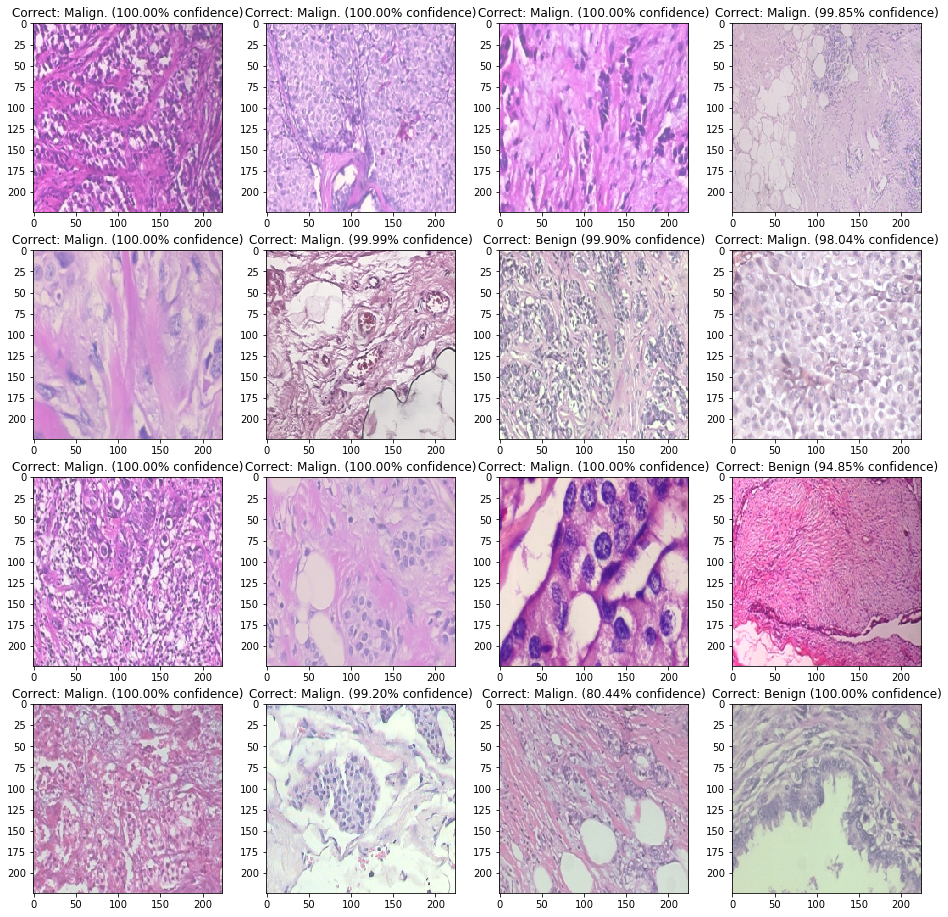

In [23]:
predictions = model.predict_classes(images_test)
print('F1 Score: %f\nRandom samples and predictions:\n' % f1_score(labels_test, predictions))

samples = 16

#random index in the test set
index = random.randint(0, len(labels_test) - samples)
#make predictions for all samples starting at that index
predictions = model.predict(images_test[index:index + samples])

fig=plt.figure(figsize=(16, 16))

for i in range(0, samples):
    ax = fig.add_subplot(samples // 4, 4, i + 1)
    title = ''
    
    confidence = predictions[i][0]
    
    if round(confidence) == labels_test[i + index]:
        title += 'Correct: '
    else:
        title += 'INCORRECT: '
    
    if labels_test[i + index] == 0:
        title += 'Benign (%.2f%% confidence)' % ((1 - confidence) * 100)
    else:
        title += 'Malign. (%.2f%% confidence)' % (confidence * 100)
    
    ax.title.set_text(title)
    plt.imshow(images_test[i + index], interpolation='nearest')
    
plt.show()